# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [6]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris', data_home='../seaborn-data-master')

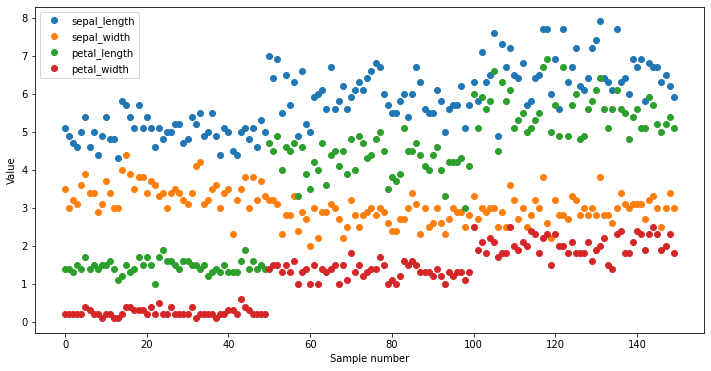

In [7]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [8]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [9]:
# organize the data


# Break the data into batches

In [10]:
def get_data(batchsize):
    iris = sns.load_dataset('iris', data_home='../seaborn-data-master')
    # use scikitlearn to split the data
    # convert from pandas dataframe to tensor
    data = torch.tensor( iris[iris.columns[0:4]].values ).float()

    # transform species to number
    labels = torch.zeros(len(data), dtype=torch.long)
    # labels[iris.species=='setosa']   = 0 # don't need!
    labels[iris.species=='versicolor'] = 1
    labels[iris.species=='virginica']  = 2

    train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)


    # finally, translate into dataloader objects
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??
    return train_loader, test_loader

# Construct the model and training plans

In [11]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.001)

  return ANNiris,lossfun,optimizer

In [12]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel(train_loader, test_loader):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses


# Test it out

In [20]:
batch_train_acc = []
batch_test_acc = []
batch_losses = []

batch_sizes = [2**i for i in range(1, 7)]

for batch_size in batch_sizes:
    # get data
    train_data, test_data = get_data(batch_size)

    # create a model
    ANNiris,lossfun,optimizer = createANewModel()

    # train the model
    trainAcc,testAcc,losses = trainTheModel(train_data, test_data)
    batch_train_acc.append(trainAcc)
    batch_test_acc.append(testAcc)
    batch_losses.append(losses)


2
4
8
16
32
64


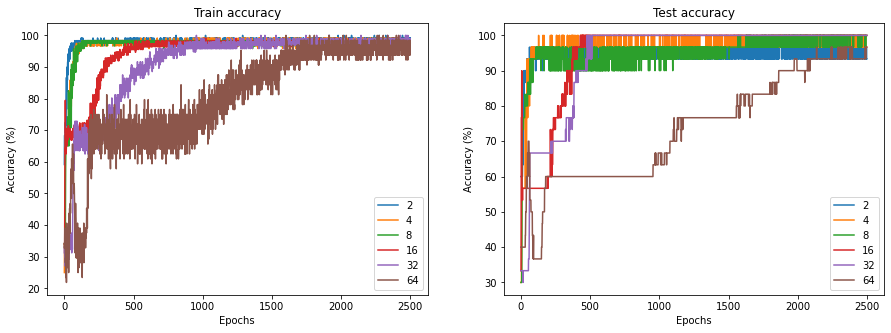

In [21]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))

for trainAcc, testAcc, losses, batch_size in zip(batch_train_acc, batch_test_acc, batch_losses, batch_sizes):
    ax[0].plot(trainAcc, label=f'{batch_size}')

    ax[1].plot(testAcc, label=f'{batch_size}')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Train accuracy')
ax[0].legend()

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Test accuracy')
ax[1].legend()

plt.show()